In [9]:
import os, sys

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
sys.path.append(str(Path.cwd().resolve().parent))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_percentage_error

from preprocess import VN30, TARGETS, preprocess_v2

In [10]:
symbol = 'ACB'

# Bước 1: Tiền xử lý dữ liệu

In [11]:
train_loader, valid_loader, test_loader, scaler = preprocess_v2(symbol, 'rnn', verbose=True)

Train shape: torch.Size([1094, 30, 4]), torch.Size([1094, 4])
Valid shape: torch.Size([121, 30, 4]), torch.Size([121, 4])


In [12]:
class Transformer(nn.Module):
    def __init__(
        self,
        input_dim: int = 4,    # số feature mỗi bước thời gian
        d_model: int = 32,     # chiều embedding
        num_heads: int = 4,    # số head
        d_ff: int = 64,        # chiều hidden của feed-forward
        dropout: float = 0.1
    ):
        super().__init__()
        self.d_model = d_model
        # 1) Embedding không thay đổi thứ tự time: (batch, seq_len, input_dim) → (batch, seq_len, d_model)
        self.embed = nn.Linear(input_dim, d_model)

        # 2) Linear cho Q, K, V mỗi head gộp chung
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.attn_drop = nn.Dropout(dropout)

        # 3) FFN nhỏ để map context → delta_price
        self.ffn = nn.Sequential(
            nn.Linear(d_model * 2, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, input_dim)
        )

    def forward(self, x: torch.Tensor):
        """
        x: (batch, seq_len, input_dim)
        return: (batch, input_dim)  -- dự đoán giá của bước tiếp theo
        """
        B, T, _ = x.shape

        # --- 1) Embed ---
        x_e = self.embed(x)                # (B, T, d_model)

        # --- 2) Query = last step, Key/Value = toàn chuỗi ---
        q = self.Wq(x_e[:, -1:, :])        # (B, 1, d_model)
        k = self.Wk(x_e)                   # (B, T, d_model)
        v = self.Wv(x_e)                   # (B, T, d_model)

        # scaled dot-product attention
        # (B, 1, d_model) @ (B, d_model, T) → (B, 1, T)
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.d_model)
        weights = F.softmax(scores, dim=-1)   # (B, 1, T)
        weights = self.attn_drop(weights)

        # context vector
        # (B, 1, T) @ (B, T, d_model) → (B, 1, d_model)
        context = weights @ v                # (B, 1, d_model)
        context = context.squeeze(1)         # (B, d_model)

        # --- 3) Skip connection: lấy embedding của bước cuối cùng ---
        last_embed = x_e[:, -1, :]           # (B, d_model)

        # --- 4) Ghép context + last_embed rồi qua FFN để predict delta ---
        rep = torch.cat([context, last_embed], dim=-1)  # (B, 2*d_model)
        delta = self.ffn(rep)                            # (B, input_dim)

        # --- 5) Dự đoán = giá cuối cùng + delta ---
        # nhớ x là giá đã được scaler transform → delta cũng phù hợp scale
        y_pred = x[:, -1, :] + delta                   # (B, input_dim)
        return y_pred

In [13]:
model = Transformer()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
criterion = nn.SmoothL1Loss()

In [14]:
best_val_loss = float('inf')
n_epochs = 50

for epoch in range(1, n_epochs + 1):
    # --- train ---
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch, y_batch
        optimizer.zero_grad()
        preds = model(X_batch)
        loss  = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)

    # --- validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch, y_batch
            preds = model(X_batch)
            val_loss += criterion(preds, y_batch).item() * X_batch.size(0)
    val_loss /= len(valid_loader.dataset)

    scheduler.step()

    # --- checkpoint ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'checkpoints/tft_{symbol}.pth')

    if epoch % 10 == 0 or epoch == n_epochs:
        print(f"Epoch {epoch:3d}/{n_epochs}: "
              f"Train Loss = {train_loss:.6f}, "
              f"Valid Loss = {val_loss:.6f}, "
              f"Best Val Loss = {best_val_loss:.6f}, "
			  f"LR = {optimizer.param_groups[0]['lr']:.6f}")

Epoch  10/50: Train Loss = 0.001568, Valid Loss = 0.000973, Best Val Loss = 0.000973, LR = 0.000800
Epoch  20/50: Train Loss = 0.001171, Valid Loss = 0.000685, Best Val Loss = 0.000685, LR = 0.000640
Epoch  30/50: Train Loss = 0.001077, Valid Loss = 0.000679, Best Val Loss = 0.000658, LR = 0.000512
Epoch  40/50: Train Loss = 0.001044, Valid Loss = 0.000704, Best Val Loss = 0.000650, LR = 0.000410
Epoch  50/50: Train Loss = 0.001027, Valid Loss = 0.000677, Best Val Loss = 0.000650, LR = 0.000328


In [15]:
model.load_state_dict(torch.load(f'checkpoints/tft_{symbol}.pth', map_location='cpu'))
model.eval()

# Thu thập dự đoán và nhãn
all_preds   = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch
        preds = model(X_batch).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(y_batch.numpy())

all_preds   = np.vstack(all_preds)   # (n_samples, 5)
all_targets = np.vstack(all_targets)

# Inverse scaling
all_preds_inv   = scaler.inverse_transform(all_preds)
all_targets_inv = scaler.inverse_transform(all_targets)

# Tính metrics
r2   = r2_score(all_targets_inv, all_preds_inv, multioutput='uniform_average')
mape = mean_absolute_percentage_error(all_targets_inv, all_preds_inv) * 100

print(f"Test R²: {r2:.4f}")
print(f"Test MAPE: {mape:.4f}%")

Test R²: 0.9229
Test MAPE: 0.7938%


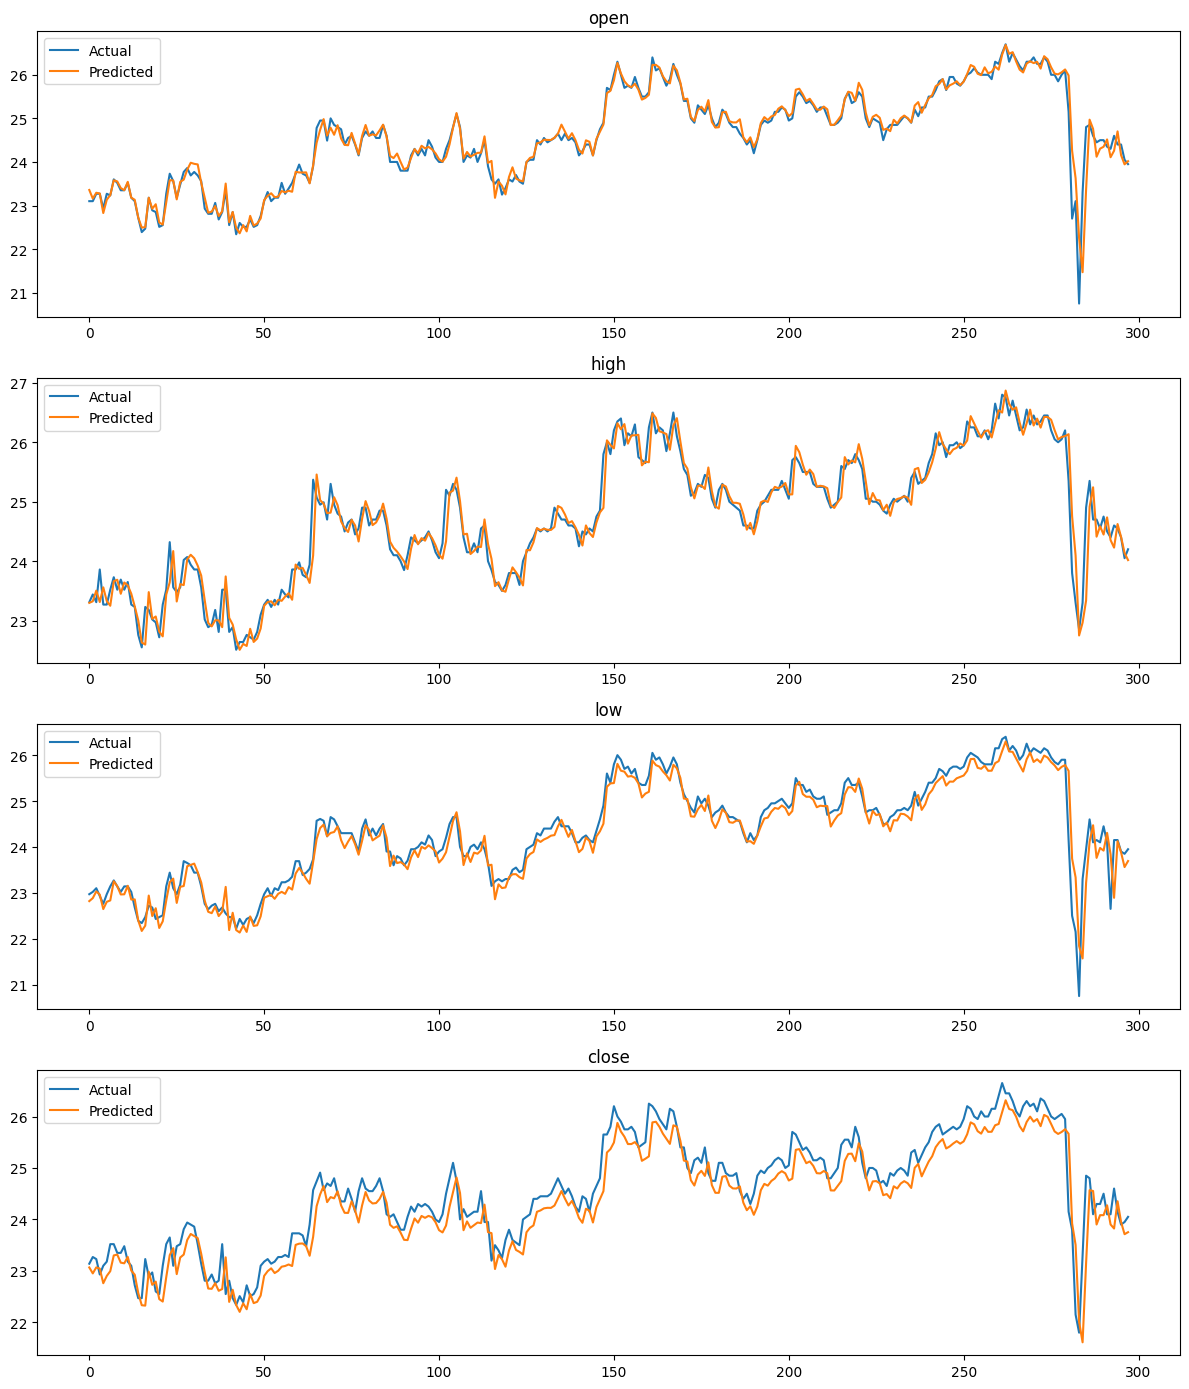

In [16]:
n = all_targets_inv.shape[1]

plt.figure(figsize=(12, 14))
for i in range(n):
    ax = plt.subplot(n, 1, i + 1)
    ax.plot(all_targets_inv[:, i], label='Actual')
    ax.plot(all_preds_inv[:, i],   label='Predicted')
    ax.set_title(TARGETS[i])
    ax.legend(loc='best')

plt.tight_layout()
plt.show()